In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import os.path
from os.path import exists
import pandas as pd
from scipy.stats import gaussian_kde

### Read in job lists

In [13]:
root = '../../..'
num_injections = 300
joblists_all = {}
joblists_inspected = {}

pop_names = ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']

for pop in pop_names:
    
    # load all jobs
    f = f'{root}/Code/IndividualInference/injlist_{pop}_' + str(num_injections) + 'events.txt'
    jobs = np.loadtxt(f)
    
    job_list = [int(job) for job in np.sort(jobs)]
    
    joblists_all[pop] = job_list
    
    # look for jobs already inspected
    f2 = f'{pop}_jobs_checked.txt'
    if exists(f2):
        job_list_inspected = np.loadtxt(f2)
        joblists_inspected[pop] = job_list_inspected
    else: 
        joblists_inspected[pop] = []

### Function to determine which jobs are done versus which aren't

In [5]:
def find_all_missing(pop, events):
    # given a population and a list of events,return a list of events that have do not exist, or are corrupt
    
    missing = []
    not_missing = []
    
    for job in events: 
        JOB=int(job) 

        f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
        file_exists = exists(f)
        if not file_exists:
            missing += [JOB]
            #print(JOB)
        else:
            try:
                # Read file
                with open(f,'r') as jf:
                    result = json.load(jf)
                chiEff = np.array(result['posterior']['content']['chi_eff'])
                not_missing += [JOB]

            except Exception as e:
                #print(JOB)
                missing += [JOB]
                #print(e)
            
    return missing, not_missing

In [14]:
joblists_finished = {}

for pop in pop_names: 
    
    print(pop)
    
    # Figure out which jobs we still need to look at
    jobs_all = joblists_all[pop]
    jobs_inspected = joblists_inspected[pop]
    jobs_remaining = [j for j in jobs_all if j not in jobs_inspected]
    
    # Look through them
    jobs_missing, job_list_finished = find_all_missing(pop, jobs_remaining)
    joblists_finished[pop] = np.concatenate((jobs_inspected, job_list_finished))
    
    # Print how many 
    print(f'{len(joblists_finished[pop])} finished, {len(job_list_finished)} to plot')
    print('missing jobs: ', jobs_missing)
    print()

population1_highSpinPrecessing
0 finished, 0 to plot
missing jobs:  [22, 27, 56, 202, 263, 278, 295, 308, 320, 326, 406, 505, 531, 549, 553, 571, 606, 624, 651, 684, 692, 697, 730, 731, 735, 742, 904, 916, 959, 973, 1005, 1007, 1014, 1018, 1035, 1045, 1053, 1096, 1110, 1131, 1203, 1215, 1216, 1254, 1284, 1306, 1406, 1410, 1411, 1489, 1506, 1530, 1599, 1656, 1687, 1716, 1735, 1793, 1824, 1829, 1836, 1840, 1868, 1884, 1925, 1977, 1986, 2007, 2018, 2038, 2059, 2071, 2076, 2081, 2092, 2110, 2329, 2374, 2451, 2469, 2507, 2527, 2565, 2599, 2607, 2608, 2620, 2627, 2637, 2810, 2841, 2909, 2911, 2913, 2965, 2970, 2976, 3047, 3058, 3062, 3112, 3114, 3145, 3150, 3195, 3353, 3493, 3501, 3504, 3518, 3617, 3680, 3688, 3751, 3801, 3804, 3825, 3828, 3874, 3934, 3948, 4064, 4087, 4134, 4237, 4241, 4288, 4295, 4339, 4370, 4388, 4427, 4435, 4448, 4530, 4548, 4566, 4601, 4609, 4648, 4660, 4691, 4734, 4746, 4752, 4753, 4855, 4893, 4940, 4956, 5022, 5080, 5184, 5203, 5220, 5222, 5223, 5230, 5237, 5297, 5309

### Plot histogram of parameters for events that have finished

In [11]:
f_root = '../../InjectedPopulationParameters/'
pop1 = pd.read_json(f_root+'population1_highSpinPrecessing.json')
pop2 = pd.read_json(f_root+'population2_mediumSpin.json')
pop3 = pd.read_json(f_root+'population3_lowSpinAligned.json')

In [15]:
params_dict = {}

for i,pop in enumerate([pop1, pop2, pop3]):
    
    chis = []
    costs = []
    chieffs = []
    chips = []
    m1s = []
    m2s = []
    qs = []
    zs = []

    for job in joblists_inspected[pop_names[i]]:
        
        JOB_ID = int(job)
        
        # masses 
        m1 = pop.m1[JOB_ID]
        m2 = pop.m2[JOB_ID]
        m1s += [m1]
        m2s += [m2]
        
        # redshift
        zs += [pop.z[JOB_ID]]
    
        # spin magnitude
        chi1 = np.sqrt(pop.s1x[JOB_ID]**2 + pop.s1y[JOB_ID]**2 + pop.s1z[JOB_ID]**2)
        chi2 = np.sqrt(pop.s2x[JOB_ID]**2 + pop.s2y[JOB_ID]**2 + pop.s2z[JOB_ID]**2)
        chis += [chi1]
        chis += [chi2]

        # tilt angle
        cost1 = pop.s1z[JOB_ID]/chi1
        cost2 = pop.s2z[JOB_ID]/chi2
        costs += [cost1]
        costs += [cost2]

        # chi effective
        q = m2/m1
        qs += [q]
        chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
        chieffs += [chieff]

        # chi p
        sint1 = np.sin(np.arccos(cost1))
        sint2 = np.sin(np.arccos(cost2))
        chip = calculate_chiP(chi1, chi2, sint1, sint2, q)
        chips += [chip]

    params_dict[pop_names[i]] = {
        'chi':chis, 
        'cost':costs, 
        'chieff':chieffs, 
        'chip':chips, 
        'm1':m1s,
        'm2':m2s,
        'q':qs,
        'z':zs
    }

In [30]:
def reflective_kde_on_grid(points, grid):
    
    A = grid[0]
    B = grid[-1]
    
    kde_on_grid = gaussian_kde(points)(grid) + gaussian_kde(-points + 2*A)(grid) + gaussian_kde(-points + 2*B)(grid)
    
    return kde_on_grid

In [39]:
# Set up grids to evaluate KDEs on
m1_grid = np.linspace(20,85,500)
m2_grid =  np.linspace(20,85,500)
q_grid =  np.linspace(0,1,500)
z_grid =  np.linspace(0.1,1.2,500)

# make and evaluate kdes
m1_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m1), np.asarray(pop2.m1), np.asarray(pop3.m1))), m1_grid)
m2_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m2), np.asarray(pop2.m2), np.asarray(pop3.m2))), m2_grid)

q = np.concatenate((np.asarray(pop1.m2/pop1.m1),  np.asarray(pop2.m2/pop2.m1),  np.asarray(pop3.m2/pop3.m1)))
q_kde = reflective_kde_on_grid(q, q_grid)

z_kde =reflective_kde_on_grid(np.concatenate((np.asarray(pop1.z), np.asarray(pop2.z), np.asarray(pop3.z))), z_grid)

# put KDEs into dict
kde_dict = {
    'm1':m1_kde, 
    'm2':m2_kde, 
    'q':q_kde, 
    'z':z_kde
}

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


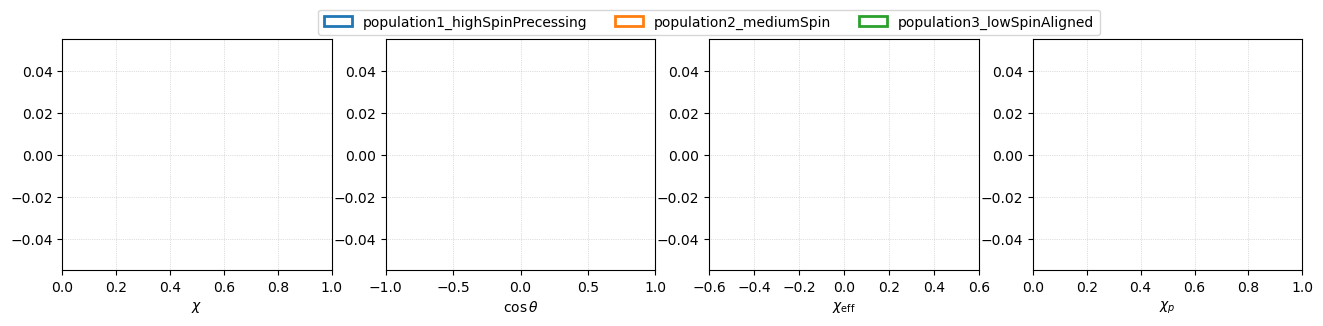

In [20]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for pop in pop_names:
    
    # spin magnitude
    axes[0].hist(params_dict[pop]['chi'], density=True, bins=np.linspace(0, 1, 20), histtype='step', lw=2, label=pop)
    axes[0].set_xlim(0,1)
    
    # tilt angle
    axes[1].hist(params_dict[pop]['cost'], density=True, bins=np.linspace(-1, 1, 20), histtype='step', lw=2)
    axes[1].set_xlim(-1,1)
    
    # chi effective
    axes[2].hist(params_dict[pop]['chieff'], density=True, bins=np.linspace(-0.6, 0.6, 20), histtype='step', lw=2)
    axes[2].set_xlim(-0.6,0.6)
    
    # chi p
    axes[3].hist(params_dict[pop]['chip'], density=True, bins=np.linspace(0, 1, 20), histtype='step', lw=2)
    axes[3].set_xlim(0, 1)
    
axes[0].legend(bbox_to_anchor=(0.95, 1.02, 1., .102), loc='lower left',
                      ncol=3,  borderaxespad=0.)
    
axes[0].set_xlabel(r'$\chi$')
axes[1].set_xlabel(r'$\cos\theta$')
axes[2].set_xlabel(r'$\chi_\mathrm{eff}$')
axes[3].set_xlabel(r'$\chi_p$')  

for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    
plt.show()

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


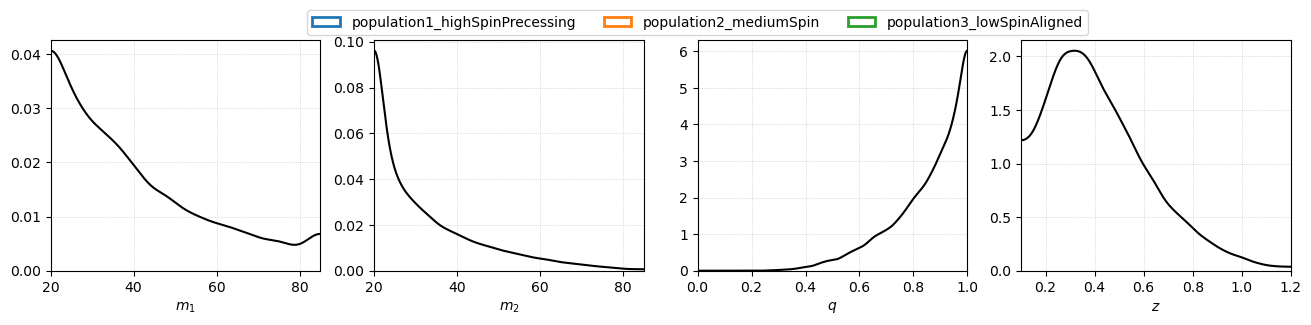

In [40]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for pop in pop_names:
    
    axes[0].hist(params_dict[pop]['m1'], density=True, histtype='step', lw=2, label=pop)
    
    axes[1].hist(params_dict[pop]['m2'], density=True, histtype='step', lw=2)
    
    axes[2].hist(params_dict[pop]['q'], density=True, histtype='step', lw=2)
    
    axes[3].hist(params_dict[pop]['z'], density=True, histtype='step', lw=2)
    
axes[0].legend(bbox_to_anchor=(0.95, 1.02, 1., .102), loc='lower left',
                      ncol=3,  borderaxespad=0.)

axes[0].plot(m1_grid, kde_dict['m1'], color='k')
axes[1].plot(m2_grid, kde_dict['m2'], color='k')
axes[2].plot(q_grid, kde_dict['q'], color='k')
axes[3].plot(z_grid, kde_dict['z'], color='k')

axes[0].set_xlim(20,85)
axes[1].set_xlim(20,85)
axes[2].set_xlim(0,1)
axes[3].set_xlim(0.1, 1.2)
    
axes[0].set_xlabel(r'$m_1$')
axes[1].set_xlabel(r'$m_2$')
axes[2].set_xlabel(r'$q$')
axes[3].set_xlabel(r'$z$')  

for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    
plt.show()

### Plots cornerplots of individual event posteriors which have not yet been investigated

In [7]:
# Function to calculate SNR 
def get_snr(H1, L1, V1): 
    
    H1_snr = np.sqrt(H1['real']**2 + H1['imag']**2)
    L1_snr = np.sqrt(H1['real']**2 + H1['imag']**2)
    V1_snr = np.sqrt(H1['real']**2 + H1['imag']**2)
    
    network_SNR = np.sqrt(H1_snr**2 + L1_snr**2 + V1_snr**2)
    
    return network_SNR

In [7]:
pop='population1_highSpinPrecessing'
#pop='population2_mediumSpin'
#pop='population3_lowSpinAligned'

for job in joblists_finished[pop]: 
    
    if job not in joblists_inspected[pop]:
    
        JOB=int(job) 
        print(JOB)

        try:
            # Read file
            f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
            with open(f,'r') as jf:
                result = json.load(jf)

            # Extract injected parameters
            inj_q = result['injection_parameters']['mass_ratio']
            inj_m1 = result['injection_parameters']['mass_1_source']
            inj_m2 = result['injection_parameters']['mass_2_source']
            inj_z = result['injection_parameters']['redshift']
            inj_chieff = result['injection_parameters']['chi_eff']
            inj_chip = result['injection_parameters']['chi_p']
            inj_chi1 = result['injection_parameters']['a_1']
            inj_chi2 = result['injection_parameters']['a_2']
            inj_costilt1 = result['injection_parameters']['cos_tilt_1']
            inj_costilt2 = result['injection_parameters']['cos_tilt_2']

            inj_Mc = (inj_q/(1.+inj_q)**2)**(3./5.)*(inj_m1+inj_m2)

            # Injected snr
            inj_snr = get_snr(result['meta_data']['likelihood']['interferometers']['H1']['matched_filter_SNR'], 
                              result['meta_data']['likelihood']['interferometers']['L1']['matched_filter_SNR'], 
                              result['meta_data']['likelihood']['interferometers']['V1']['matched_filter_SNR'])

            inj_params = [inj_q,inj_Mc,inj_z,inj_chieff,inj_chip,inj_chi1,inj_chi2,inj_costilt1,inj_costilt2,inj_snr]

            print(inj_params)

            # Extract posterior samples
            m1 = np.array(result['posterior']['content']['mass_1_source'])
            m2 = np.array(result['posterior']['content']['mass_2_source'])
            z = np.array(result['posterior']['content']['redshift'])
            chiEff = np.array(result['posterior']['content']['chi_eff'])
            chiP = np.array(result['posterior']['content']['chi_p'])
            chi1 = np.array(result['posterior']['content']['a_1'])
            chi2 = np.array(result['posterior']['content']['a_2'])
            cost1 = np.array(result['posterior']['content']['cos_tilt_1'])
            cost2 = np.array(result['posterior']['content']['cos_tilt_2'])

            # Convert to mass ratio and chirp mass
            q = m2/m1
            Mc = (q/(1.+q)**2)**(3./5.)*(m1+m2)

            # Calculate SNR 
            snr = np.asarray([get_snr(result['posterior']['content']['H1_matched_filter_snr'][i], 
                              result['posterior']['content']['L1_matched_filter_snr'][i], 
                              result['posterior']['content']['V1_matched_filter_snr'][i]) for i in range(len(result['posterior']['content']['L1_matched_filter_snr']))])

            # Make a corner plot of the posterior samples
            labels = [r"$q$",r"$\mathcal{M}_c$",r'$z$',r'$\chi_\mathrm{eff}$',r'$\chi_\mathrm{p}$',
                      r"$\chi_1$",r"$\chi_2$",r"$\cos\theta_1$",r"$\cos\theta_2$", "snr"]
            ndim = len(labels)
            fig = corner(np.transpose([q,Mc,z,chiEff,chiP,chi1,chi2,cost1,cost2,snr]),labels=labels,fontsize=18)
            axes = np.array(fig.axes).reshape((ndim, ndim))

            # Overplot injected values as horizontal/vertical lines
            for i in range(ndim):
                ax = axes[i, i]
                ax.axvline(inj_params[i], color="black")
            for yi in range(ndim):
                for xi in range(yi):
                    ax = axes[yi, xi]
                    ax.axvline(inj_params[xi], color="black")
                    ax.axhline(inj_params[yi], color="black")

            plt.suptitle(f'Job # {JOB}', fontsize=16)
            plt.savefig('./cornerplots_{1}/job_{0:05d}_result.json'.format(JOB, pop))
            plt.show()

            print()

        except Exception as e:
            print(e)
            
# Save the list of jobs we have already plotted             
np.savetxt(f'{pop}_jobs_checked.txt',joblists_finished[pop],fmt="%d")